In [1]:
from data_formats import read_data
from dose_reponse_fit import dose_response_fit, StandardSettings
import matplotlib.pyplot as plt
from plotting import *
from stress_survival_conversion import stress_to_survival, survival_to_stress
import random
import glob
import pandas as pd
from tqdm import tqdm
from scipy.stats import beta, gamma, expon, weibull_min, lognorm, norm, t, pareto
from torch.optim.lr_scheduler import LinearLR
import torch
import numpy as np
import torch.nn as nn
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
class LearnableCumDistribution(nn.Module):
    
    def __init__(self, n_buckets : int) -> None:
        super().__init__()
        
        self.n_buckets = n_buckets
        self.logits = nn.Parameter(torch.ones(self.n_buckets, dtype=torch.float32) / self.n_buckets, requires_grad= True)
        self.borders = nn.Parameter(torch.linspace(0, 1, n_buckets + 1), requires_grad=False)
            
    def get_cum_prob(self, indices):
        softmax = torch.nn.functional.softmax(self.logits, dim=-1)
        cum_probs = torch.cumsum(softmax, dim=-1)
        cum_probs = torch.cat([torch.tensor([0.0], device=self.logits.device), cum_probs])  # Add 0 for the 0th border

        return cum_probs.gather(0, indices.flatten()).reshape(indices.shape)
    
    def forward(self, x):
        if torch.any(x < 0) or torch.any(x > 1):
            raise ValueError("Only probs between 0 and 1")
        
        right_borders = torch.searchsorted(self.borders, x, right=True)
        right_borders = torch.clamp(right_borders, 1, self.n_buckets)
        left_borders = right_borders - 1
        
        right_vals = self.get_cum_prob(right_borders)
        left_vals = self.get_cum_prob(left_borders)
        
        interpolation_rate = (x - self.borders[left_borders]) * self.n_buckets
        
        return (1 - interpolation_rate) * left_vals + interpolation_rate * right_vals
    
    def inverse(self, x):
        if torch.any(x < 0) or torch.any(x > 1):
            raise ValueError("Only probs between 0 and 1")

        softmax = torch.nn.functional.softmax(self.logits, dim=-1)
        
        cum_probs = torch.cumsum(softmax, dim=-1)
        cum_probs = torch.cat([torch.tensor([0.0], device=self.logits.device), cum_probs]) 
        
        
        # Find which bucket the value `x` falls into using a searchsorted-like mechanism
        right_borders = torch.searchsorted(cum_probs, x, side="right")
        right_borders = torch.clamp(right_borders, 1, self.n_buckets)
        left_borders = right_borders - 1

        # Get cumulative probabilities for left and right borders
        right_vals = cum_probs[right_borders]
        left_vals = cum_probs[left_borders]
        
  

        # Linear interpolation to determine the exact value in the input space
        interpolation_rate = (x - left_vals) / (right_vals - left_vals + 1e-7)  # small epsilon for numerical stability
        if torch.any(interpolation_rate > 1.1):
            
            mask = interpolation_rate > 1
            
            func = lambda x: print(x.detach().cpu().numpy())
            func(left_vals[mask])
            func(x[mask])
            func(right_vals[mask])
            
            print("wtf", interpolation_rate.max())
        return self.borders[left_borders] + interpolation_rate * (self.borders[right_borders] - self.borders[left_borders])

        
    
    def to_df(self):
        
        return pd.DataFrame({
            "right_borders" : self.borders[1:].detach().cpu().numpy(),
            "probs" : nn.functional.softmax(self.logits, 0).detach().cpu().numpy(),
        })
        
model = LearnableCumDistribution(1000)

xs = torch.tensor([0.01, 0.320, 0.34,0.2232,0.2131, 0.99])

for x in xs:
    print(x, model.inverse(x))
    print()

tensor(0.0100) tensor(0.0100, grad_fn=<AddBackward0>)

tensor(0.3200) tensor(0.3200, grad_fn=<AddBackward0>)

tensor(0.3400) tensor(0.3400, grad_fn=<AddBackward0>)

tensor(0.2232) tensor(0.2232, grad_fn=<AddBackward0>)

tensor(0.2131) tensor(0.2131, grad_fn=<AddBackward0>)

tensor(0.9900) tensor(0.9900, grad_fn=<AddBackward0>)



In [3]:
files = []

for i in glob.glob("data/*.xlsx"):
    data = read_data(i)
    
    # if data.meta.chemical in ["Clothianidin", "Esfenvalerate", "BPS"]:
    files.append(data)
        
        
fits = []
for data in files:
    data : ExperimentData
    for stressor in data.additional_stress:
        
        settings = StandardSettings(survival_max=data.meta.max_survival, len_curves = 1000)

        main_fit = dose_response_fit(data.main_series, settings)

        stress_fit = dose_response_fit(data.additional_stress[stressor], settings)
        
        fits.append((data, stressor, main_fit, stress_fit))
xs, ys = [], []
main_c0, stress_c0 = [], []

for data, stressor, main_fit, stress_fit in fits:
    
    main_fit : ModelPredictions
    stress_fit : ModelPredictions
    
    if stress_fit.optim_param["d"] > main_fit.optim_param["d"]:
        print("dropping")
        continue
    
    if np.mean(main_fit.survival_curve > stress_fit.survival_curve) < 0.9:
        print("drop weird data")
        continue
    
    xs.append(main_fit.survival_curve / data.meta.max_survival)
    main_c0.append(main_fit.optim_param["d"])
    stress_c0.append(stress_fit.optim_param["d"])
    
    ys.append(stress_fit.survival_curve / data.meta.max_survival)
    
    
toxicant_surv = np.array(xs)
stres_surv = np.array(ys)
main_c0 = np.array(main_c0)
stress_c0 = np.array(stress_c0)
toxicant_surv.min(), toxicant_surv.max(), stres_surv.min(), stres_surv.max(), toxicant_surv.shape, stres_surv.shape

drop weird data
drop weird data
drop weird data


(0.00017854006518621809,
 0.9999996553905022,
 8.132729453932944e-07,
 0.9999932415573746,
 (39, 1000),
 (39, 1000))

Step: 1, Loss: 0.0147993295, LR: 0.001000:   0%|          | 0/10000 [00:00<?, ?it/s]

Step: 9999, Loss: 0.0024162305, LR: 0.000000: 100%|██████████| 10000/10000 [00:50<00:00, 197.77it/s]


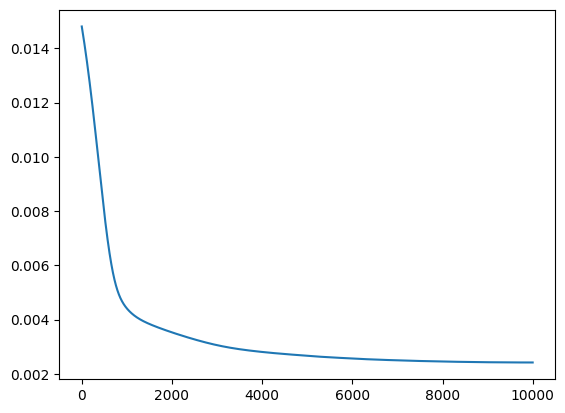

In [5]:
N_SAMPLES = 10000
N_PARAMS = 5000

STEPS = 10000
LR = 1e-3
DEVICE = "cuda"
REG_FAC = 0.1


model = LearnableCumDistribution(n_buckets=N_PARAMS)
tox_torch = torch.tensor(toxicant_surv, dtype=torch.float32, device=DEVICE)
stress_torch = torch.tensor(stres_surv, dtype=torch.float32, device=DEVICE)
main_c0_torch = torch.tensor(main_c0, dtype=torch.float32, device=DEVICE)
stress_c0_torch = torch.tensor(stress_c0, dtype=torch.float32, device=DEVICE)



model = model.to(device=DEVICE)

optim = torch.optim.Adam(model.parameters(), lr=LR)

# Linear LR decay function
lambda_lr = lambda step: 1 - step / STEPS
scheduler = LinearLR(optim, 1, 1e-7, total_iters=STEPS)

bar = tqdm(range(STEPS))

criterion = nn.MSELoss()

def to_stress(x):
    return model(1-x)

losses = []

for step in bar:
    optim.zero_grad()
    
    tox_stress = to_stress(tox_torch)
    
    main_c0_stress = to_stress(main_c0_torch)
    tox_c0_stress = to_stress(stress_c0_torch)
    
    added_stress = tox_c0_stress - main_c0_stress
    
    sam_stress = tox_stress + added_stress[:,None]
    
    sam_pred = 1 - model.inverse(torch.clamp(sam_stress, 0, 1))
    
    loss = criterion(stress_torch, sam_pred)
    
    probs = nn.functional.softmax(model.logits, 0)
    probs_diff = probs[1:] - probs[:-1]
    smoothness_reg = torch.sum(probs_diff ** 2)
    
    loss += smoothness_reg * REG_FAC
    
    loss.backward()
    optim.step()
    
    # Update the learning rate
    scheduler.step()

    bar.set_description(f"Step: {step}, Loss: {float(loss.item()):.10f}, LR: {scheduler.get_last_lr()[0]:.6f}")
    losses.append(loss.item())
    
plt.plot(losses)
plt.show()

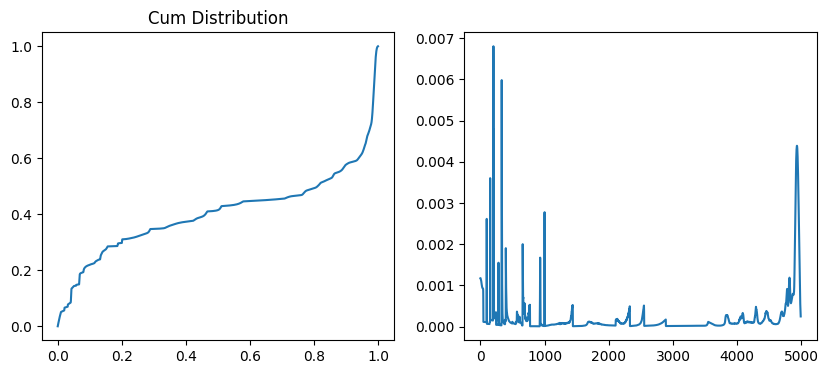

In [6]:
x = np.linspace(0,1, 10000)
y = model(torch.tensor(x, dtype=torch.float32, device=DEVICE)).detach().cpu().numpy()

plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.plot(x,y)
plt.title("Cum Distribution")

k = nn.functional.softmax(model.logits, 0).detach().cpu().numpy()[5:-5]

plt.subplot(1,2,2)
plt.plot(k)
plt.show()

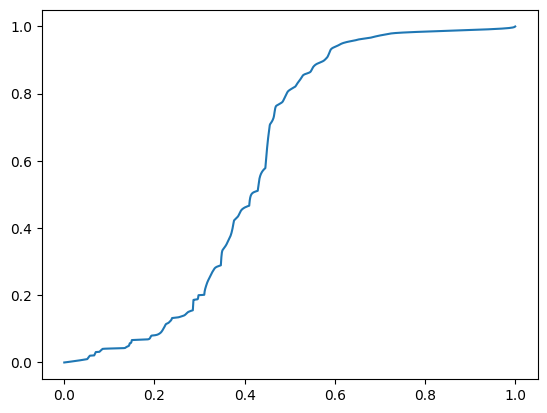

In [7]:
x = torch.linspace(0,1,10000,device=DEVICE)
inverse = model.inverse(x).detach().cpu().numpy()
plt.plot(x.cpu(), inverse)

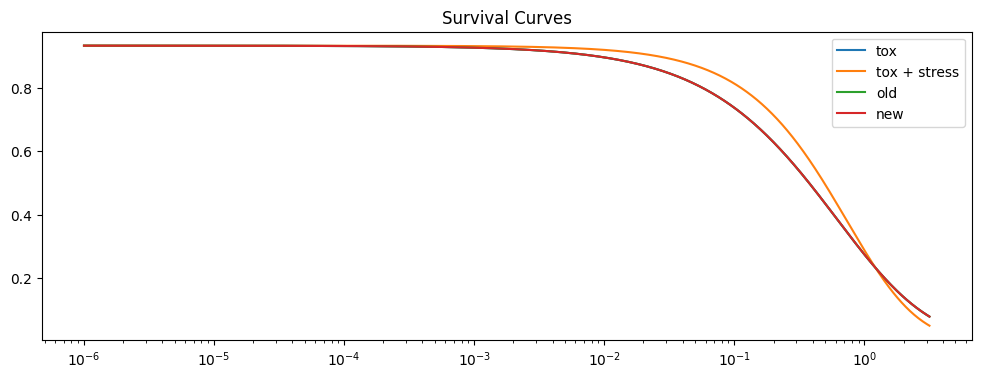

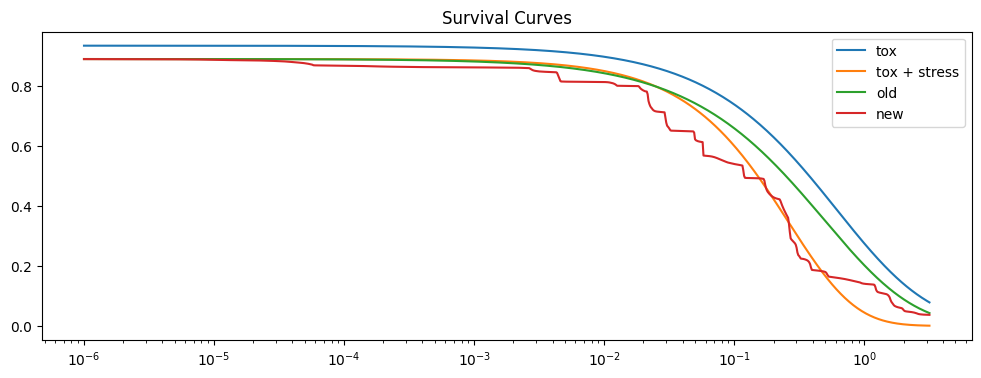

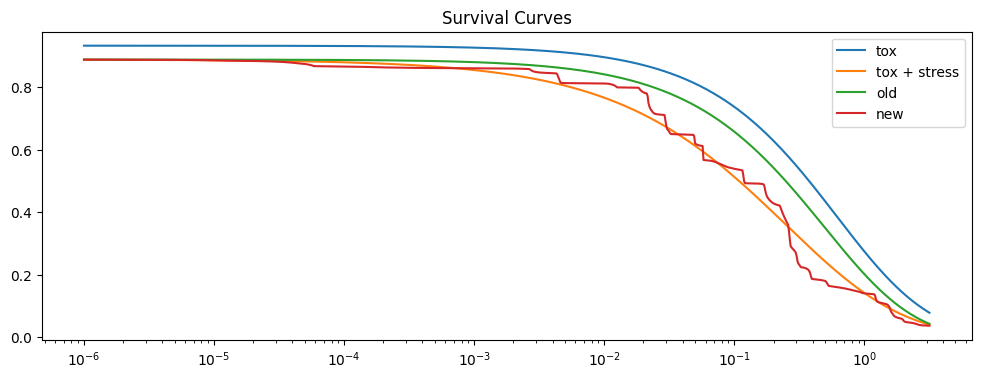

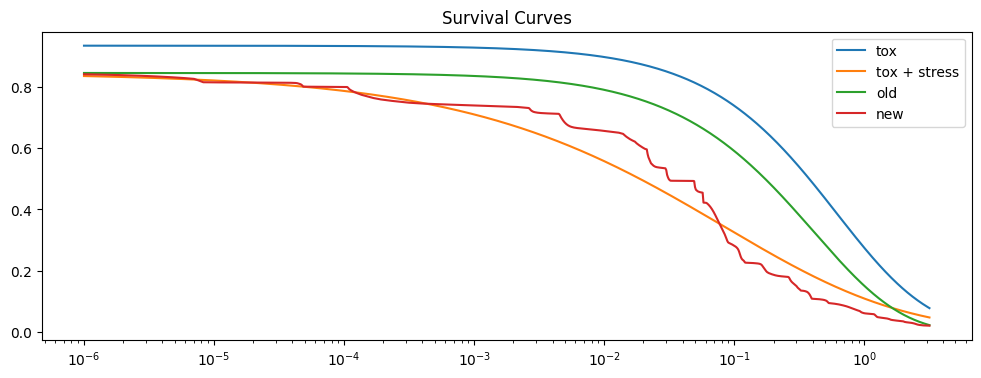

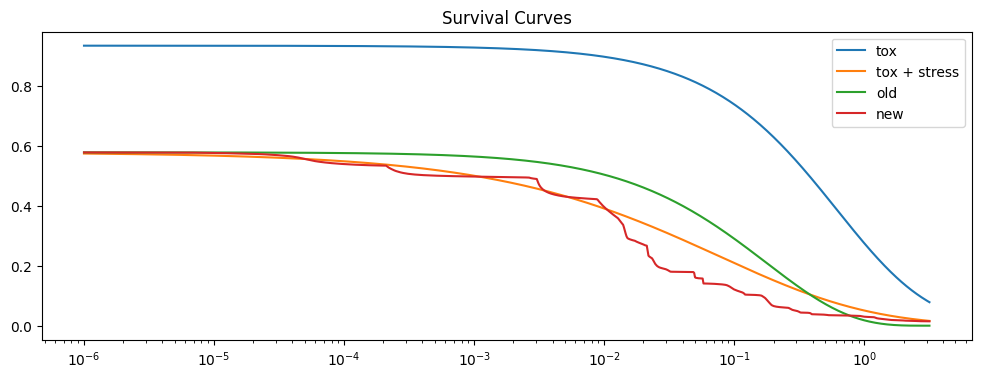

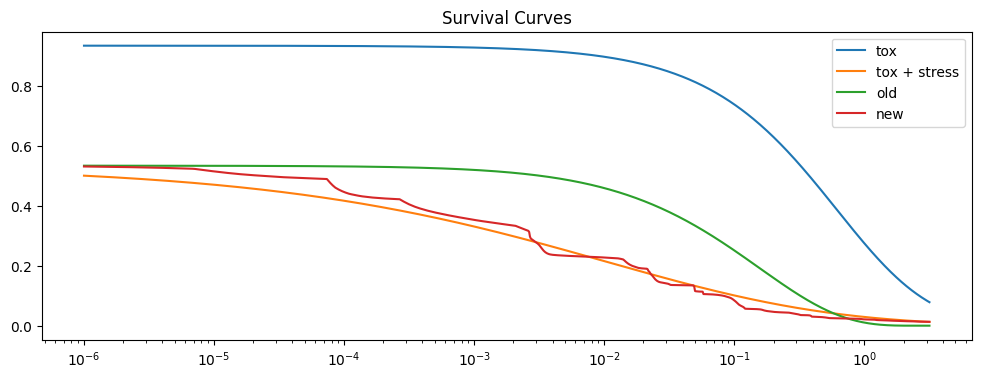

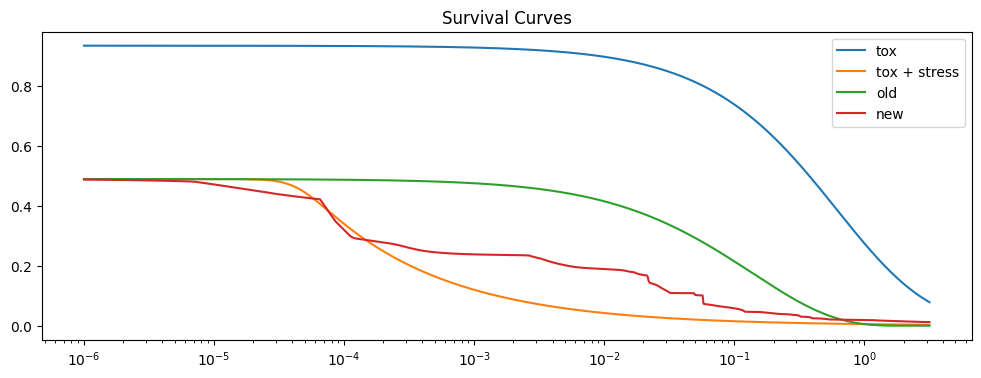

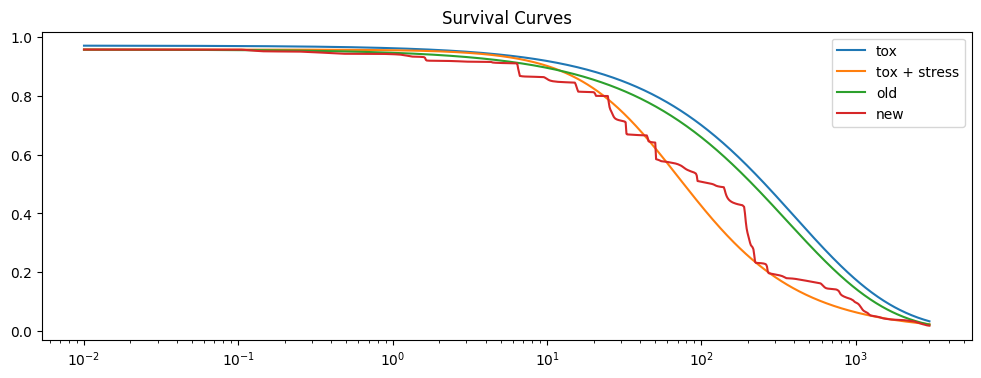

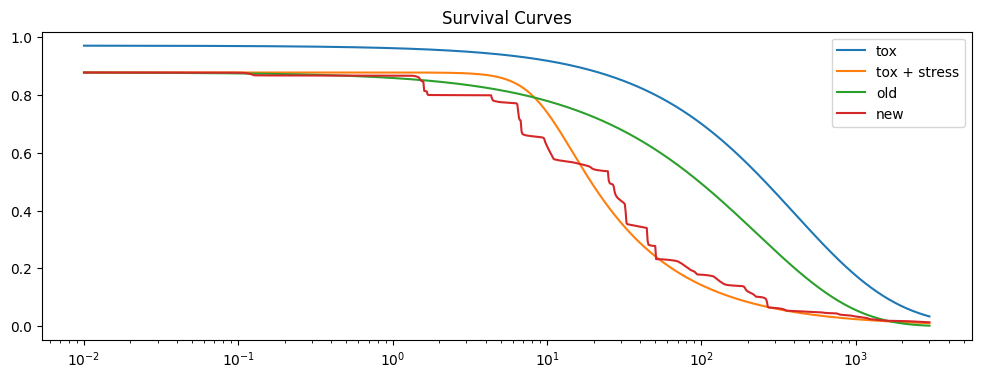

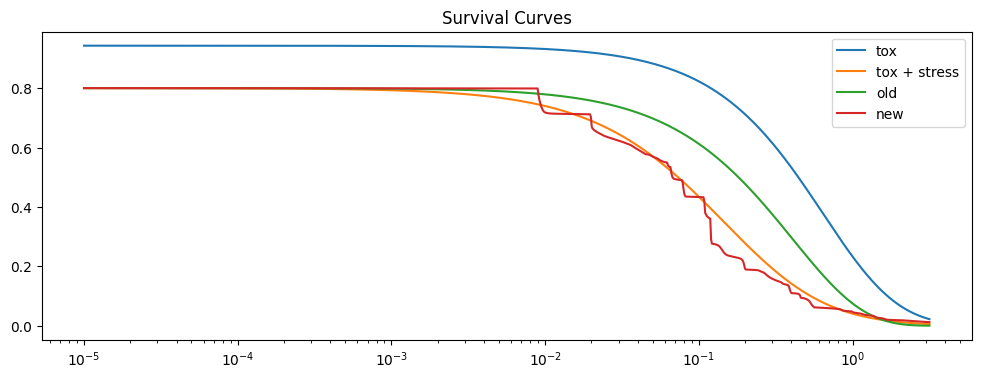

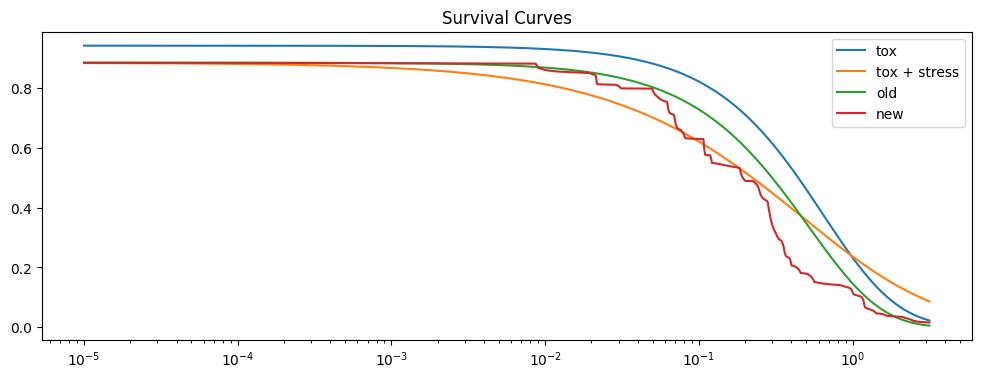

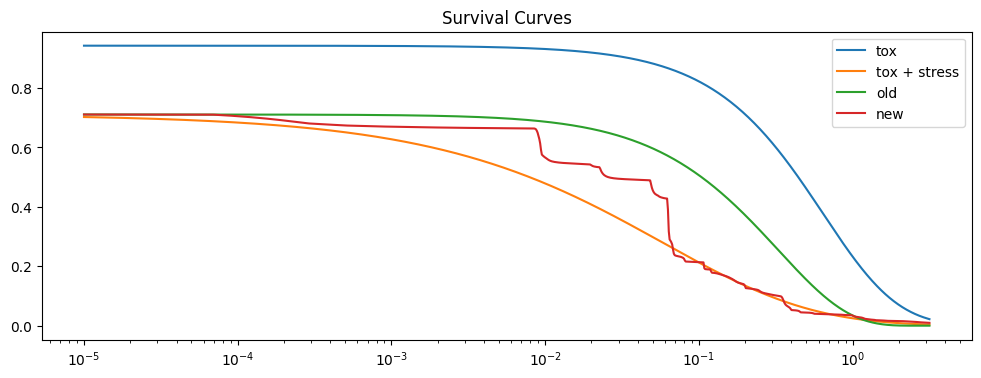

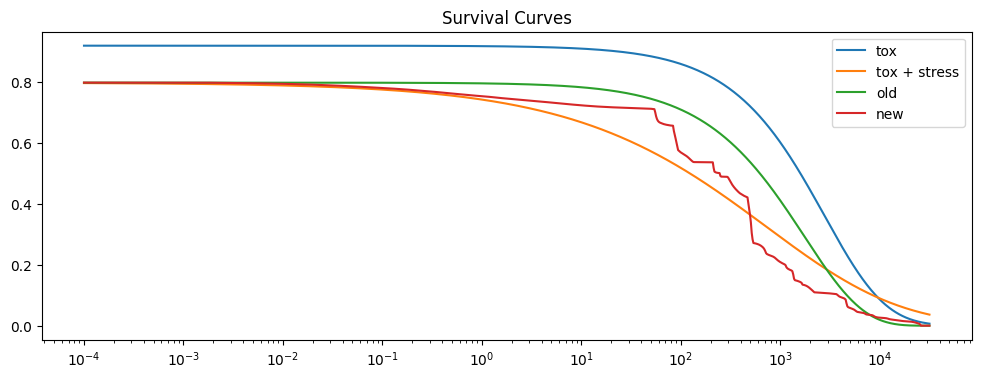

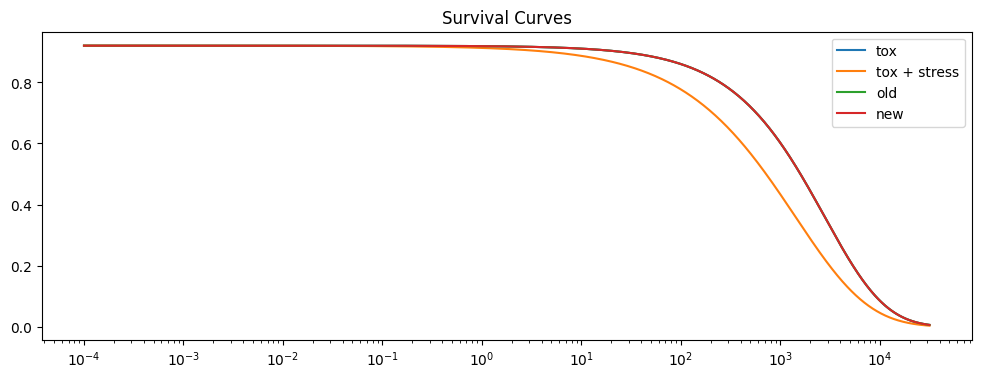

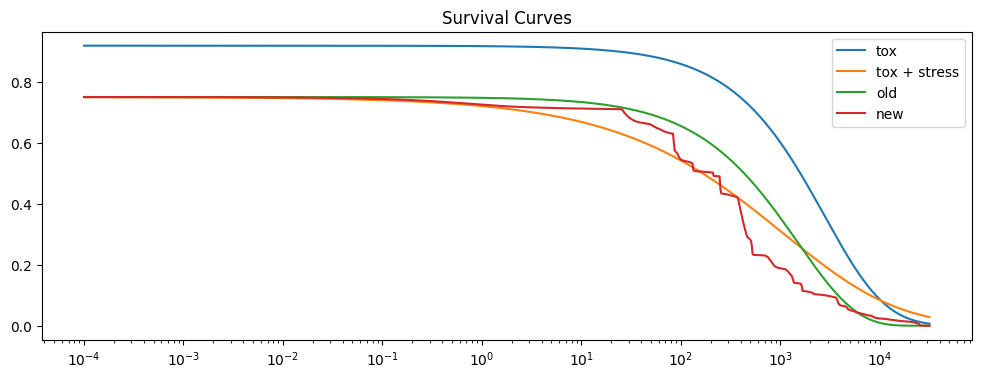

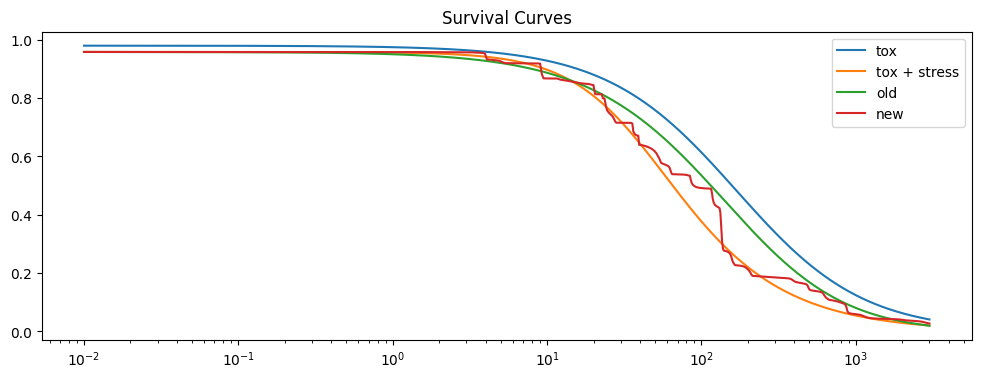

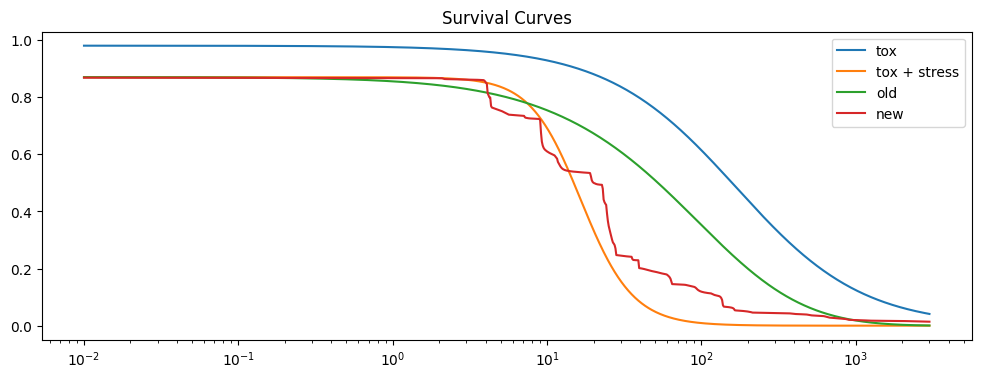

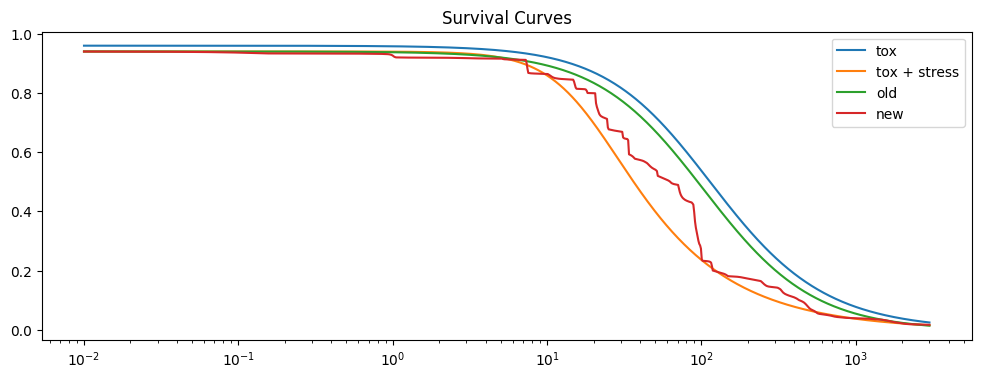

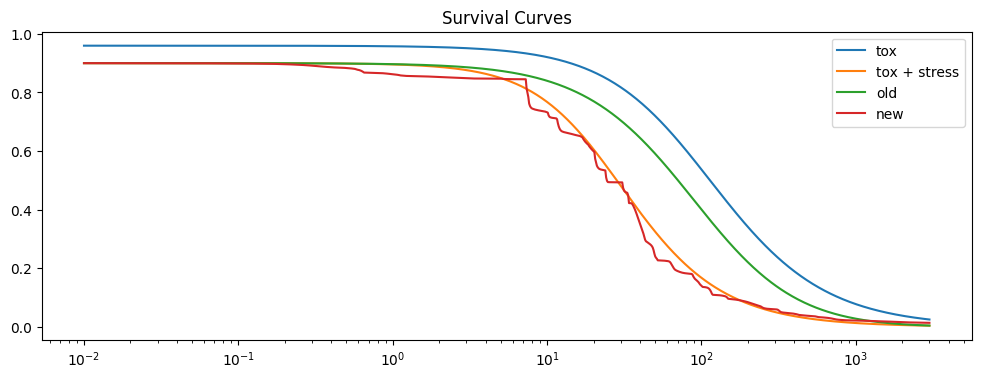

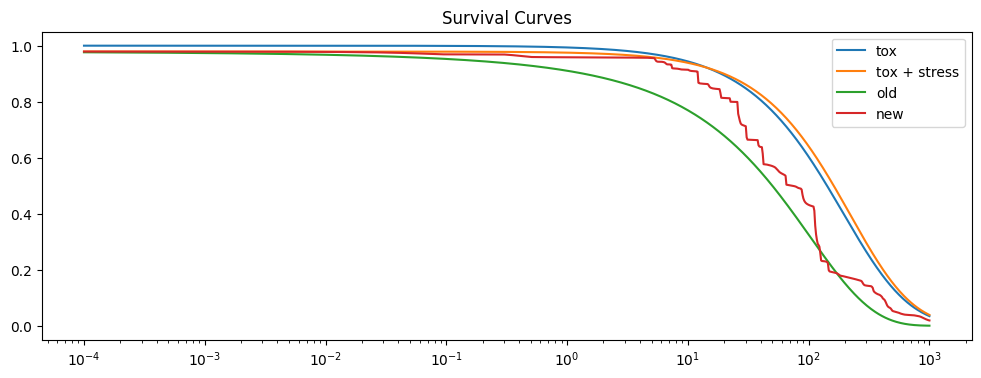

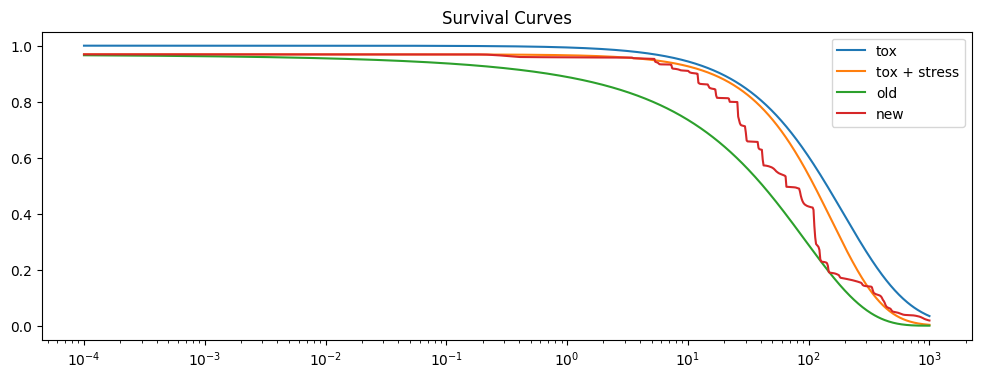

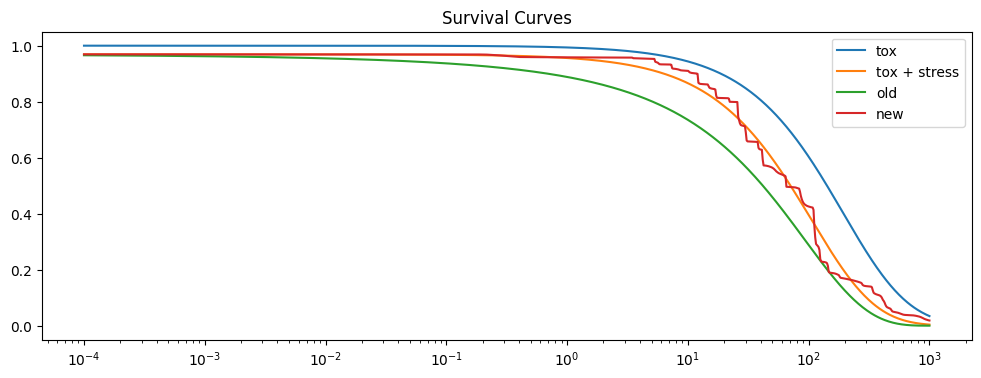

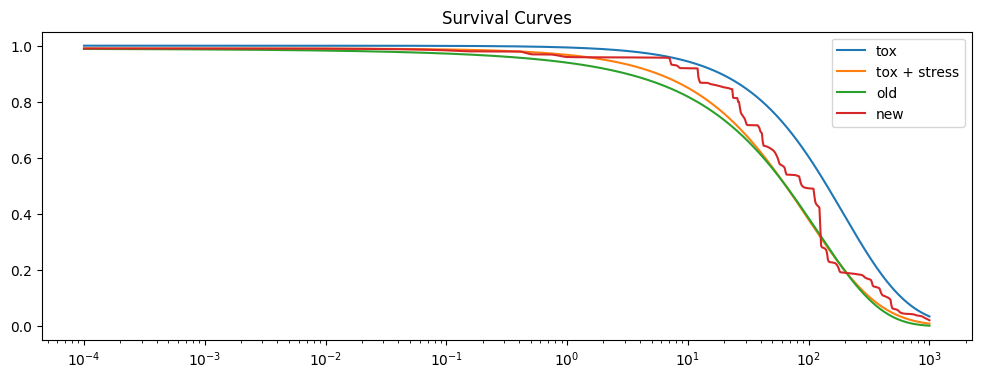

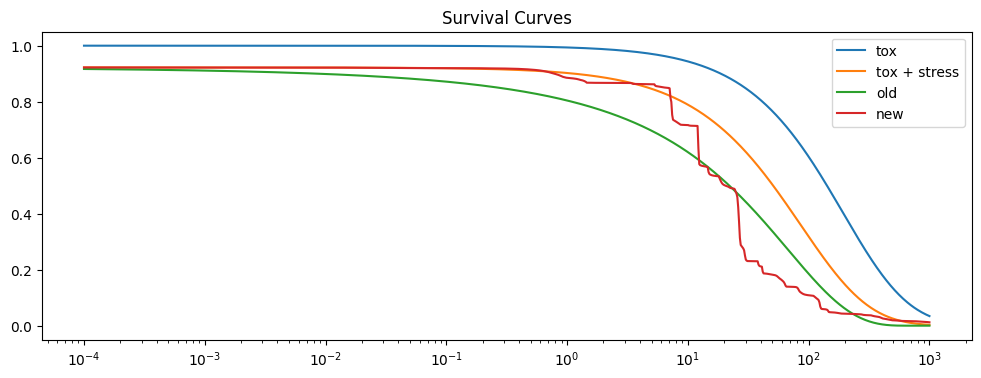

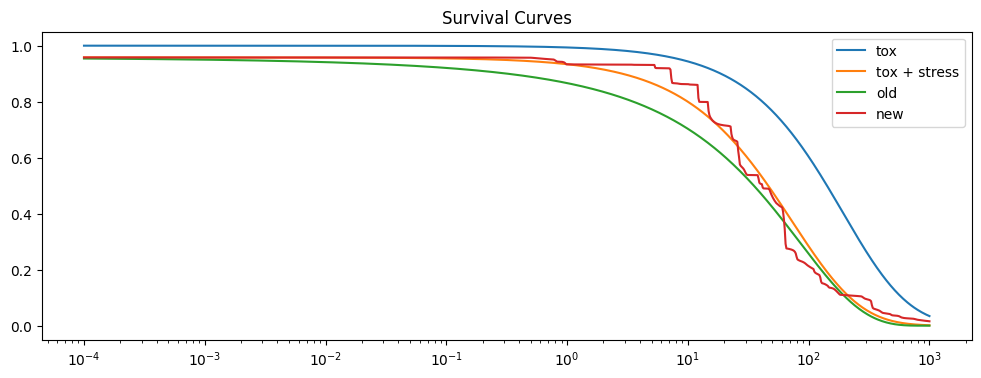

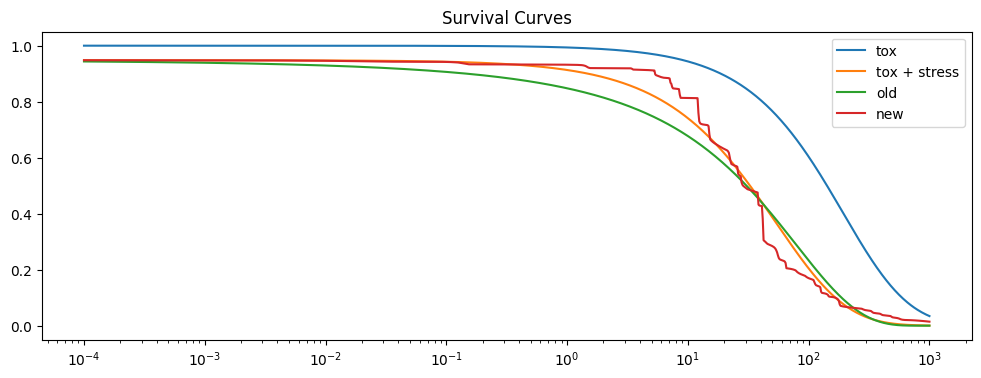

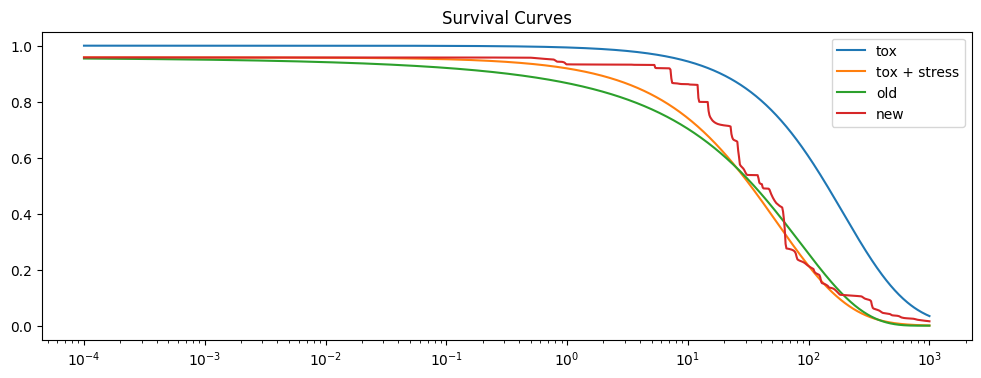

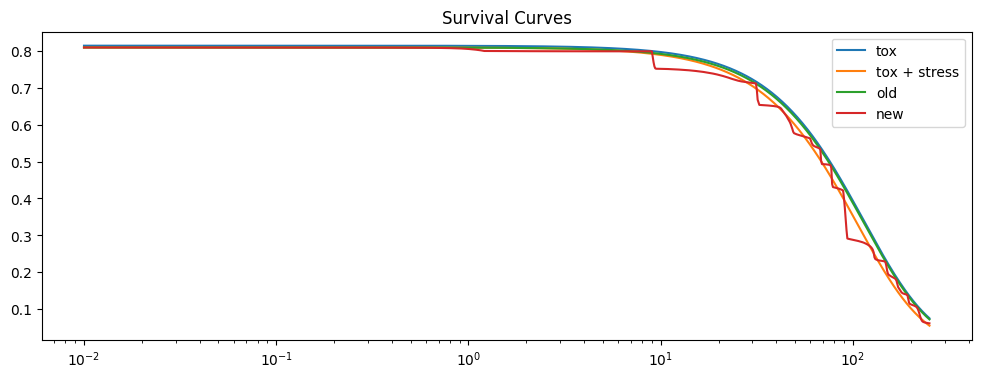

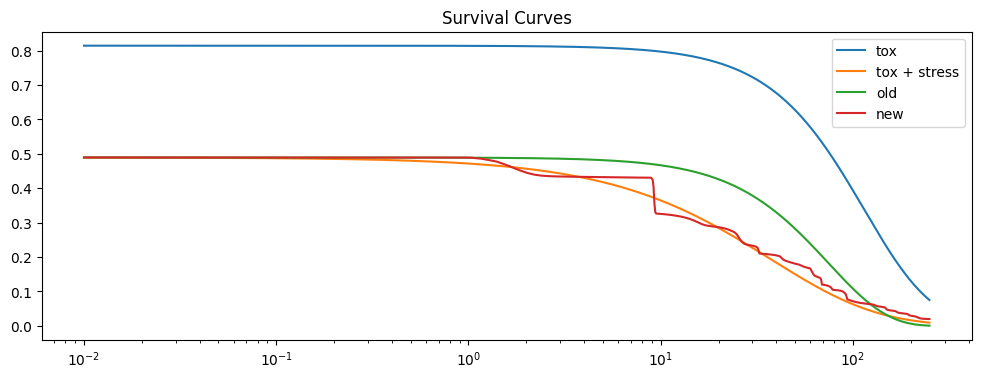

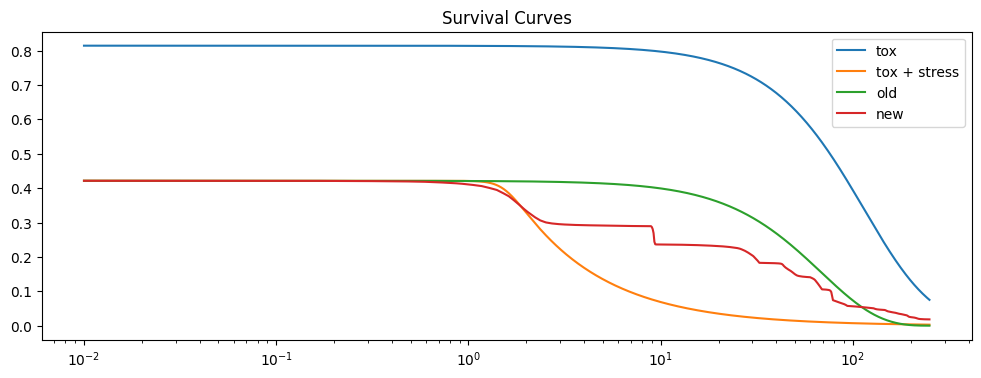

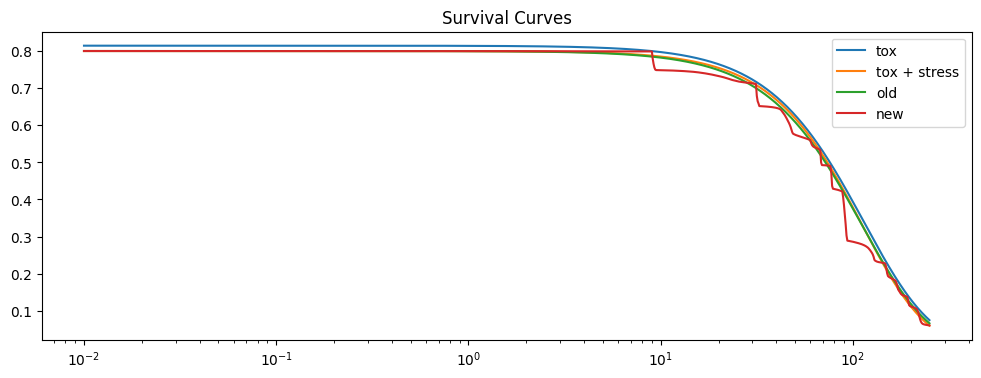

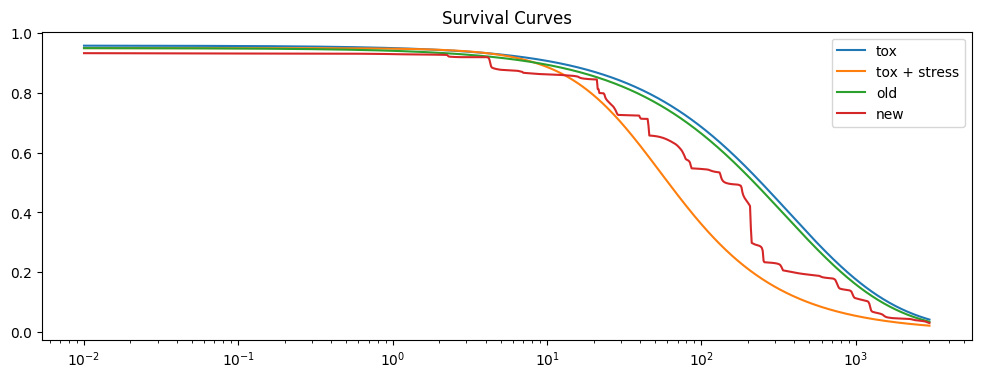

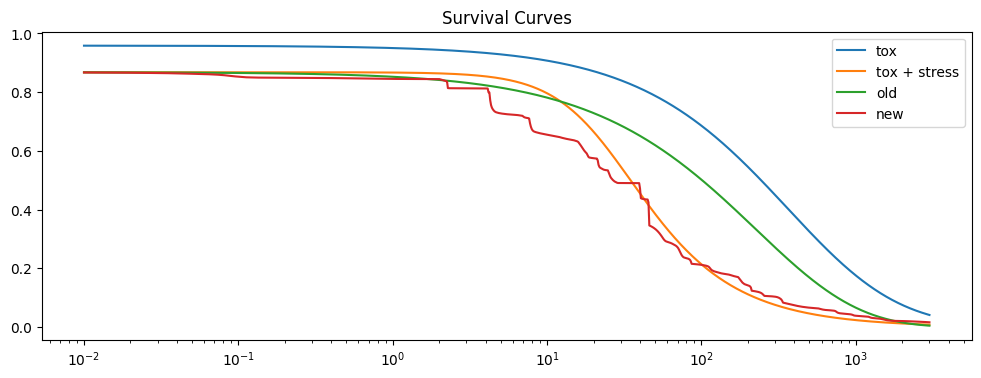

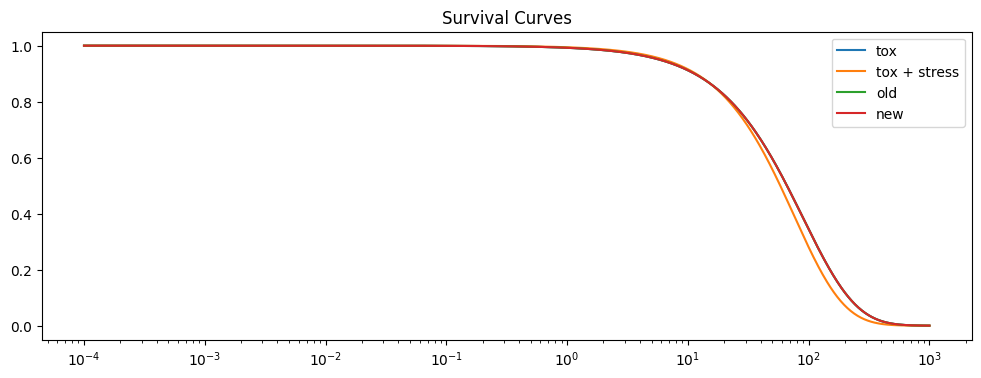

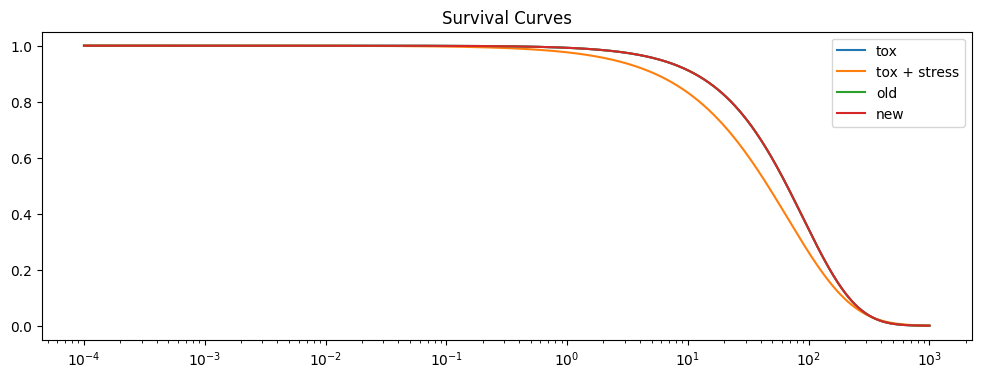

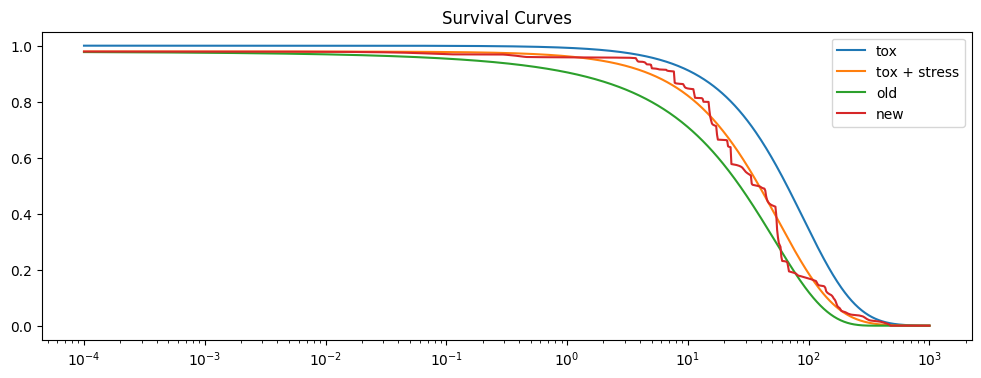

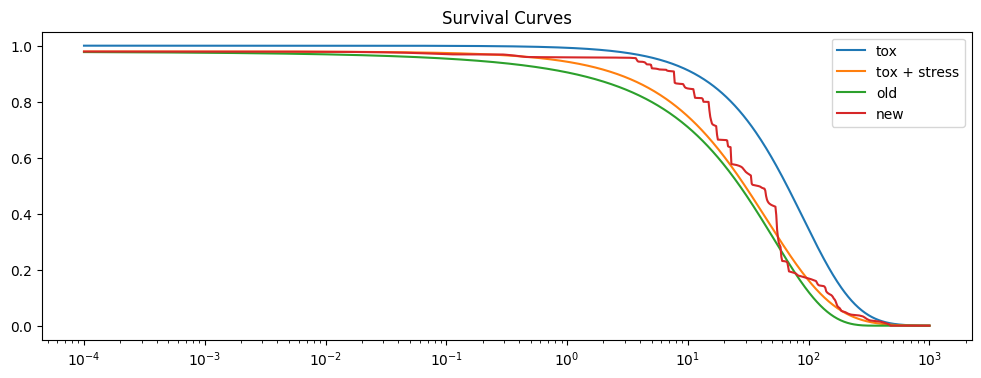

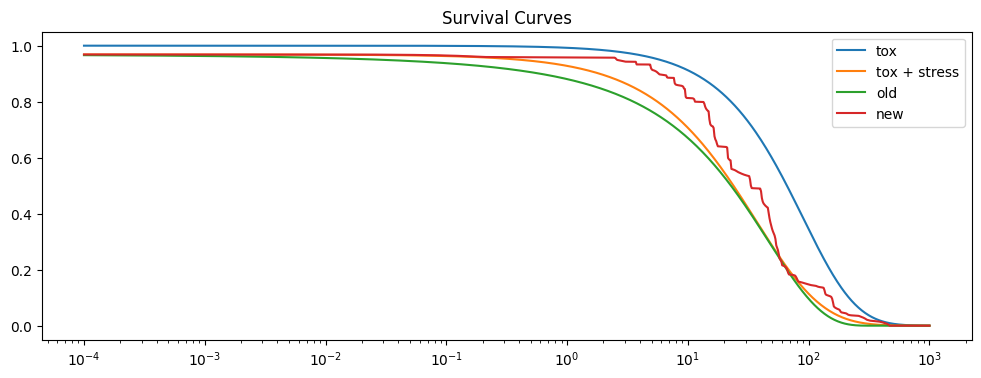

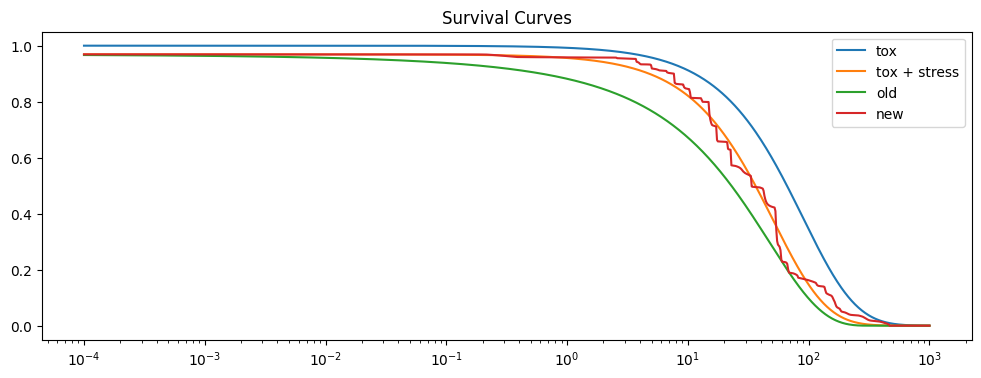

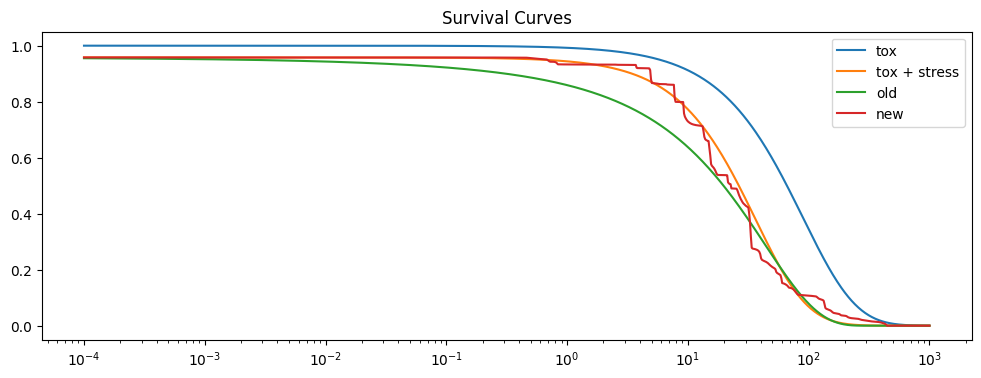

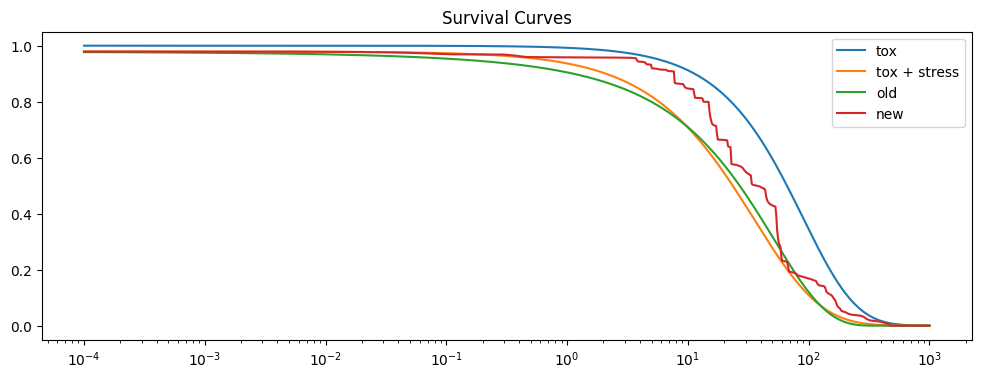

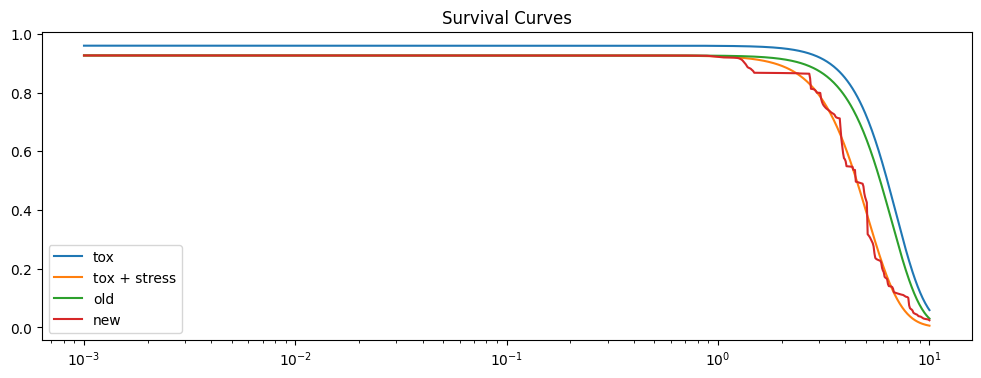

In [8]:
def sam_new(surv, main_c0, stress_c0):
    
    to_tens = lambda x : torch.tensor(x, dtype=torch.float32, device=DEVICE)
    
    surv, main_c0, stress_c0 = map(to_tens, (surv, main_c0, stress_c0))
    
    surv_stress, main_c0_stress, stress_c0_stress = map(to_stress, (surv, main_c0, stress_c0))
    sam_stress = surv_stress + stress_c0_stress - main_c0_stress
    
    
    return 1 - model.inverse(torch.clamp(sam_stress, 0, 1)).detach().cpu().numpy()


def to_stres_new(x):
    return model(torch.tensor(1 - x, dtype=torch.float32, device=DEVICE)).detach().cpu().numpy()



for data, stressor, main_fit, stress_fit in fits:
    
    surv = main_fit.survival_curve / data.meta.max_survival
    surv_stress = stress_fit.survival_curve / data.meta.max_survival
    main_c0 = main_fit.optim_param["d"]
    stress_c0 = stress_fit.optim_param["d"]
    
    plt.figure(figsize=(12,4))
    plt.plot(main_fit.concentration_curve, surv, label = "tox")
    plt.plot(main_fit.concentration_curve, surv_stress, label = "tox + stress")
    plt.title("Survival Curves")
    
    old_sam_pred = stress_to_survival(survival_to_stress(surv) + survival_to_stress(stress_c0) -survival_to_stress(main_c0))
    
    plt.plot(main_fit.concentration_curve, old_sam_pred, label = "old")
    
    
    new_sam_pred = sam_new(surv, main_c0, stress_c0)
    plt.plot(main_fit.concentration_curve, new_sam_pred, label = "new")
    
    plt.legend()
    plt.xscale("log")
    plt.show()

In [9]:
model.to_df().to_csv("better2.csv")